# Load OpenMonkeyStudio Data

In [22]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import transform_frame
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir' : '/data/LiftFly3D/openmonkey/OMS_Dataset/', # change the path 
       'out_dir'        : './out',
       'subjects'       : ["7", "9", "9a", "9b", "10", "11"],
        'train_subjects': ["7", "9a", "9b", "10", "11"],
        'test_subjects' : ["9"]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
cameras, pose_result = load_data(par['data_dir'], par["subjects"])

# split data into training and test
train_2d = {k:np.array(v["points2d"]) for (k,v) in pose_result.items() if k in par["train_subjects"]}
test_2d = {k:np.array(v["points2d"]) for (k,v) in pose_result.items() if k in par["test_subjects"]}
train_3d = {k:np.array(v["points3d"]) for (k,v) in pose_result.items() if k in par["train_subjects"]}
test_3d = {k:np.array(v["points3d"]) for (k,v) in pose_result.items() if k in par["test_subjects"]}


# convert 3d points into camera frame
for btch in train_3d.keys():
    for idx in range(train_3d[btch].shape[0]):
        cam_id = pose_result[btch]['cam_id'][idx]
        R, T, intr, distort, vis_pts = cameras[btch][cam_id]
        train_3d[btch][idx] = world_to_camera2(train_3d[btch][idx].copy(), R, T)
        
for btch in test_3d.keys():
    for idx in range(test_3d[btch].shape[0]):
        cam_id = pose_result[btch]['cam_id'][idx]
        R, T, intr, distort, vis_pts = cameras[btch][cam_id]
        test_3d[btch][idx] = world_to_camera2(test_3d[btch][idx].copy(), R, T)


# 3d points bone-length normalize
for btch in train_3d.keys():
    train_3d[btch] = bone_length_normalize(template=train_3d['7'], d=train_3d[btch])
    
for btch in test_3d.keys():
    test_3d[btch] = bone_length_normalize(template=train_3d['7'], d=test_3d[btch])
        
# unit norm of 2d points
train_2d = {k: v / np.linalg.norm(v.reshape(v.shape[0],-1), axis=1)[:,np.newaxis,np.newaxis] for (k,v) in train_2d.items()}
test_2d = {k: v / np.linalg.norm(v.reshape(v.shape[0],-1), axis=1)[:,np.newaxis,np.newaxis] for (k,v) in test_2d.items()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
processing batch 7
processing batch 9
processing batch 9a
processing batch 9b
processing batch 10
processing batch 11


In [3]:
def world_to_camera2(P, R, T):
    """
  Rotate/translate 3d poses to camera viewpoint
  Args
    P: Nx3 points in world coordinates
    R: 3x3 Camera rotation matrix
    T: 3x1 Camera translation parameters
  Returns
    transf: Nx2 points on camera
  """

    ndim = P.shape[1]
    P = np.reshape(P, [-1, 3])

    assert len(P.shape) == 2
    assert P.shape[1] == 3

    P_rot = np.matmul(R, P.T).T + T

    return np.reshape(P_rot, [-1, ndim])

# Train LiftPose3D Network on DeepFly3D Data

In [ ]:
from liftpose.main import train as lp3d_train

lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           **{k:par[k] for k in ['roots', 'target_sets', 'out_dir']})

[main.py:163]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/openmonkey/out/stat_2d.pth.tar.
[main.py:185]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/openmonkey/outstat_3d.pth.tar.
[main.py:212]:INFO:Starting training model.
[main.py:221]:DEBUG:
==================Options=================
[main.py:222]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/openmonkey/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/openmonkey/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/openmonkey/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:223]:DEBUG:===============================

Epoch 0 | Loss Test 0 | Loss Train 0.77486|: 100%|██████████| 6366/6366 [01:16<00:00, 83.16it/s] 
/home/user/Desktop/LiftPose3D/liftpose/lifter/test.py:101: RuntimeWarning: Mean of empty slice
  joint_err = np.nanmean(all_dist, axis=0)
Epoch 1 | Loss Test 0.25334 | Loss Train 0.67435|:   9%|▉         | 598/6366 [00:08<01:12, 79.53it/s]

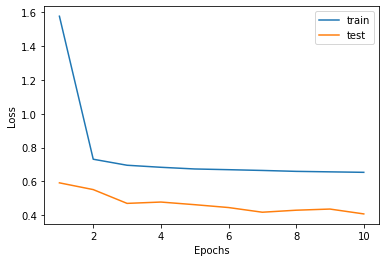

In [15]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [16]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:245]:INFO:starting testing in path: ./out
[lift.py:30]:INFO:Training on the device: cuda:0
[lift.py:58]:INFO:total params: 4.27M
[lift.py:64]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:72]:INFO:ckpt loaded (epoch: 10 | err: 0.5866420785530043)
[lift.py:110]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/openmonkey/out/test_results.pth.tar


# Run Trained LiftPose3D Network on the Test Data

In [17]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred = load_test_results(data, stat_2d, stat_3d)

In [21]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

t = 50
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"]) 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …